### 정형데이터 2차함수

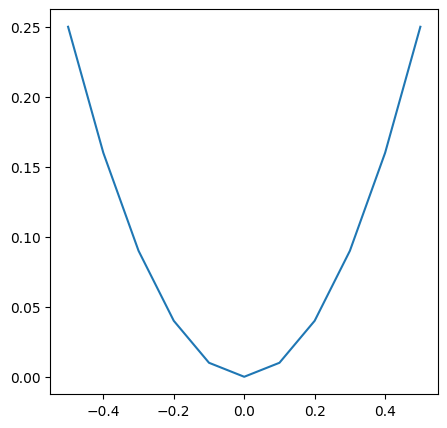

In [2]:
from matplotlib import pyplot as plt

def calculate(x):
    return x * x

inputs = [-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5]
outputs = [calculate(x) for x in inputs]

plt.figure(figsize=(5,5))
plt.plot(inputs, outputs)

plt.show()

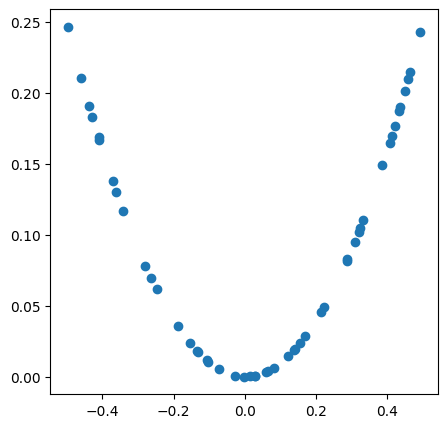

In [3]:
# 랜덤 데이터 생성

import numpy as np

def generate_samples(n=50):
    X1 = np.random.rand(n) - 0.5 # (0.0 ~ 1.0) - 0.5 = -0.5 ~ 0.5
    X2 = X1 * X1

    X1 = X1.reshape(n, 1)
    X2 = X2.reshape(n, 1)

    return np.hstack((X1, X2))

data = generate_samples()

plt.figure(figsize=(5,5))
plt.scatter(data[:, 0], data[:, 1])

plt.show()

In [4]:
from numpy import hstack
from numpy import zeros
from numpy import ones
from numpy.random import rand
from numpy.random import randn
from keras.models import Sequential
from keras.layers import Dense

# 판별 모형
def define_discriminator(n_inputs=2):
    model = Sequential()
    model.add(Dense(25, activation='relu', input_dim=n_inputs))    
    model.add(Dense(1, activation='sigmoid')) #이진분류(0,1)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [5]:
# 생성 모형
def define_generator(latent_dim, n_outputs=2):
    model = Sequential()    
    model.add(Dense(15, activation='relu', input_dim=latent_dim))
    model.add(Dense(n_outputs, activation='linear'))

    return model

# 테스트를 위한 모형
def define_gan(generator, discriminator):
    # 추론모드
    discriminator.trainable = False
    model = Sequential()
    model.add(generator) #생성 모형
    model.add(discriminator) #판별 모형
    model.compile(loss='binary_crossentropy', optimizer='adam')

    return model

# real data 생성
def generate_real_samples(n):
    X1 = np.random.rand(n) - 0.5  # -0.5 ~ 0.5
    X2 = X1 * X1

    X1 = X1.reshape(n, 1)
    X2 = X2.reshape(n, 1)

    X = hstack((X1, X2))
    y = ones((n, 1))

    return X, y

# 랜덤 데이터 생성 함수
def generate_latent_points(latent_dim, n):
    x_input = randn(latent_dim * n)
    x_input = x_input.reshape(n, latent_dim)

    return x_input

# fake data 생성
def generate_fake_samples(generator, latent_dim, n):
    x_input = generate_latent_points(latent_dim, n)

    X = generator.predict(x_input)
    y = zeros((n, 1))

    return X, y

In [6]:
from IPython.display import clear_output
import time

def summarize_performance(epoch, generator, discriminator, latent_dim, n=50):
    # 판별모형 평가(real)
    x_real, y_real = generate_real_samples(n)
    _, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)

    # 판별모형 평가(fake)
    x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
    _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)

    print(epoch, acc_real, acc_fake)

    plt.figure(figsize=(5,5))
    plt.scatter(x_real[:, 0], x_real[:, 1], color='red', label='real')
    plt.scatter(x_fake[:, 0], x_fake[:, 1], color='blue', label='fake')
    plt.xlim([-0.7, 0.7])  
    plt.ylim([-0.1, 0.4])     

    plt.show()

    clear_output(wait=True)

    time.sleep(0.5)

In [7]:
def train(g_model, d_model, gan_model, latent_dim, n_epochs=10000, n_batch=25, n_eval=5):
    half_batch = int(n_batch / 2)

    for i in range(n_epochs):
        # 판별모형 훈련
        # real data 훈련
        x_real, y_real = generate_real_samples(half_batch)
        d_model.train_on_batch(x_real, y_real)

        # fake data 훈련
        x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        d_model.train_on_batch(x_fake, y_fake)      

        # 생성모델에 입력할 x 데이터
        x_gan = generate_latent_points(latent_dim, n_batch)

        # 생성모델에 입력할 y 데이터(1)
        y_gan = ones((n_batch, 1))

        # 생성모델 훈련
        gan_model.train_on_batch(x_gan, y_gan)

        if (i+1) % n_eval == 0:
            summarize_performance(i, g_model, d_model, latent_dim)

In [8]:
# size of the latent space, 잠재공간 사이즈
latent_dim = 5

# 판별모형 생성
discriminator = define_discriminator()

In [9]:
# 생성모형 생성
generator = define_generator(latent_dim)

In [10]:
# GAN 모형 생성
gan_model = define_gan(generator, discriminator)

2/2 [==============================] - 0s 0s/step
9999 0.6600000262260437 0.41999998688697815


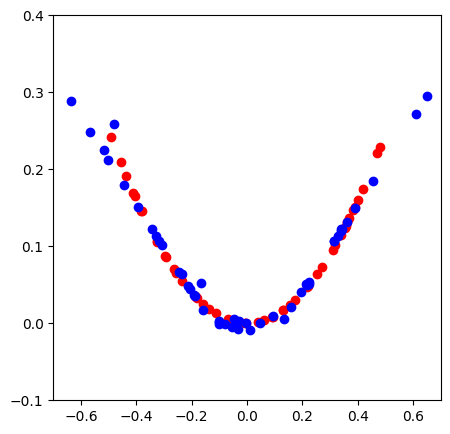

In [11]:
train(generator, discriminator, gan_model, latent_dim)

# epochs / real accuracy / fake accuracy
#9999 0.23999999463558197 0.5799999833106995